# Sparkify Project
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). 

Sparkify is a music streaming service similar to Spotify, and the project objective is to understand user behaviors related to churn rate and build models to predict churn. We will use Spark, a big data analytics tool, to clean and wrangle data and build machine learning models. 


In [60]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnan, when, count, round
from pyspark.sql.types import IntegerType
from pyspark.sql import Window
from pyspark.sql.functions import desc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import avg

from pyspark.ml.classification import LogisticRegression, LinearSVC, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import datetime
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [61]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

## Load and Clean Dataset

In [62]:
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [63]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [64]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [65]:
# row count
df.count()

286500

In [66]:
df.groupby("page").count().sort("count",ascending=False).show()

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|                Home| 14457|
|           Thumbs Up| 12551|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|               Login|  3241|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|                Help|  1726|
|            Settings|  1514|
|               About|   924|
|             Upgrade|   499|
|       Save Settings|   310|
|               Error|   258|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+
only showing top 20 rows



In [67]:
# number of songs in dataset
df.filter(df.page == "NextSong").count()

228108

In [68]:
df.describe("artist","sessionId","userId").show()

+-------+------------------+-----------------+-----------------+
|summary|            artist|        sessionId|           userId|
+-------+------------------+-----------------+-----------------+
|  count|            228108|           286500|           286500|
|   mean| 551.0852017937219|1041.526554973822|59682.02278593872|
| stddev|1217.7693079161374|726.7762634630741|109091.9499991047|
|    min|               !!!|                1|                 |
|    max| ÃÂlafur Arnalds|             2474|               99|
+-------+------------------+-----------------+-----------------+



There is invalid data in userId, and we need to figure out what it is and clean data.

In [69]:
df.select([(round(count(when(isnan(c) | col(c).isNull(), c))/count(lit(1)),4)).alias(c) for c in df.columns[:8]]).show()

+------+----+---------+------+-------------+--------+------+-----+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|
+------+----+---------+------+-------------+--------+------+-----+
|0.2038| 0.0|   0.0291|0.0291|          0.0|  0.0291|0.2038|  0.0|
+------+----+---------+------+-------------+--------+------+-----+



In [70]:
df.select([(round(count(when(isnan(c) | col(c).isNull(), c))/count(lit(1)),4)).alias(c) for c in df.columns[8:]]).show()

+--------+------+----+------------+---------+------+------+---+---------+------+
|location|method|page|registration|sessionId|  song|status| ts|userAgent|userId|
+--------+------+----+------------+---------+------+------+---+---------+------+
|  0.0291|   0.0| 0.0|      0.0291|      0.0|0.2038|   0.0|0.0|   0.0291|   0.0|
+--------+------+----+------------+---------+------+------+---+---------+------+



In [71]:
# invalid data is not missing value
df.count()

286500

In [72]:
# a further look shows that it's empty string
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [73]:
# a small portion of data has empty userId
df.filter(df["userId"] == "").count()

8346

Let's check behaviors of these users with empty userID before we do anything about it.

In [74]:
# all pages
df.select("page").dropDuplicates().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Submit Registration'),
 Row(page='Settings'),
 Row(page='Login'),
 Row(page='Register'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [75]:
## blank userId visited pages
df.filter(df.userId == "").select("page").dropDuplicates().collect()

[Row(page='Home'),
 Row(page='About'),
 Row(page='Submit Registration'),
 Row(page='Login'),
 Row(page='Register'),
 Row(page='Help'),
 Row(page='Error')]

Blank userId are guest who just look around Sparkiy platform, so we drop them from the dataset

In [76]:
df = df.filter(df.userId != "")
df.count()

278154

In [77]:
# sessionId looks okay
df.select("sessionId").dropDuplicates().sort("sessionId").show()

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



## Exploratory Data Analysis

### Define Churn

We will define churn as the group of users (both paid and free) who cancel their accounts, and the cancellation event is "Cancellation Confirmation" page.

In [78]:
df.filter("page = 'Cancellation Confirmation'").head()

Row(artist=None, auth='Cancelled', firstName='Adriel', gender='M', itemInSession=104, lastName='Mendoza', length=None, level='paid', location='Kansas City, MO-KS', method='GET', page='Cancellation Confirmation', registration=1535623466000, sessionId=514, song=None, status=200, ts=1538943990000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"', userId='18')

In [79]:
## we flag the cancellation event 1 in cancel column
cancel_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("cancel", cancel_event("page"))
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', cancel=0)

All events of churned users will have 1 in Churn column and 0 otherwise.

In [80]:
#  we flag churned users 1 on all event records before their cancellation and 0 otherwise by creating Churn column.
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
df = df.withColumn("Churn", Fsum("cancel").over(windowval))

In [81]:
df.select(["userId", "firstname", "ts", "page","method","sessionId","song", "level", "Churn"]).where(df.userId == "100014").sort("ts").head()

Row(userId='100014', firstname='Rodrigo', ts=1539177136000, page='NextSong', method='PUT', sessionId=37, song='Welcome To The World of The Plastic Beach (Feat. Snoop Dogg and Hypnotic Brass Ensemble)', level='paid', Churn=1)

### Explore Data
Exploratory Data Analysis on the groups who stayed and churned

In [82]:
# About 16% churn rate
df.groupby("Churn").count().show()

+-----+------+
|Churn| count|
+-----+------+
|    0|233290|
|    1| 44864|
+-----+------+



In [83]:
stayCount = df.groupby("Churn").count().collect()[0][1]
churnCount = df.groupby("Churn").count().collect()[1][1]

Text(0,0.5,'Number of users')

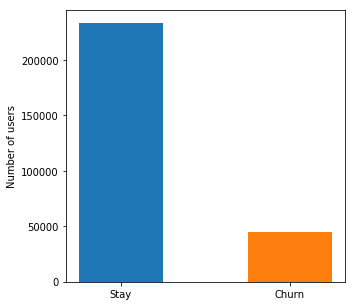

In [84]:
plt.figure(figsize = (5,5))
plt.bar(0, [stayCount], width=0.1)
plt.bar(.2, [churnCount], width=0.1)
plt.xticks([0,.2],["Stay","Churn"])
plt.ylabel("Number of users")

Let's see how the two groups behave differently like the number of songs listened.

In [85]:
song_event = udf(lambda x: 1 if x == "NextSong" else 0, IntegerType())
df = df.withColumn("listen", song_event("page"))

On average, users who stayed listened to 1108 songs and users who churned listened to 699 songs

In [86]:
staySongs = df.filter("Churn == 0 and listen == 1").groupby("userId").count().agg({"count":"avg"}).collect()[0][0]
churnSongs = df.filter("Churn == 1 and listen == 1").groupby("userId").count().agg({"count":"avg"}).collect()[0][0]
print("Stay: ",staySongs, " Churn: ", churnSongs)

Stay:  1108.1734104046243  Churn:  699.8846153846154


In [87]:
## look at similar metrics in thumbs down, help, error, roll advert pages
thumbsdown_event = udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())
df = df.withColumn("ThumbsDown", thumbsdown_event("page"))
help_event = udf(lambda x: 1 if x == "Help" else 0, IntegerType())
df = df.withColumn("Help", help_event("page"))
error_event = udf(lambda x: 1 if x == "Error" else 0, IntegerType())
df = df.withColumn("Error", error_event("page"))
ad_event = udf(lambda x: 1 if x == "Roll Advert" else 0, IntegerType())
df = df.withColumn("Ad", ad_event("page"))


Avergae number of thumbs down

In [88]:
stayDown = df.filter("Churn == 0 and ThumbsDown == 1").groupby("userId").count().agg({"count":"avg"}).collect()[0][0]
churnDown = df.filter("Churn == 1 and ThumbsDown == 1").groupby("userId").count().agg({"count":"avg"}).collect()[0][0]
print("Stay: ",stayDown, " Churn: ", churnDown)

Stay:  13.225806451612904  Churn:  10.333333333333334


Avergae number of getting help

In [89]:
stayHelp = df.filter("Churn == 0 and Help == 1").groupby("userId").count().agg({"count":"avg"}).collect()[0][0]
churnHelp = df.filter("Churn == 1 and Help == 1").groupby("userId").count().agg({"count":"avg"}).collect()[0][0]
print("Stay: ",stayHelp, " Churn: ", churnHelp)

Stay:  8.154362416107382  Churn:  5.558139534883721


Avergae number of getting error page

In [90]:
stayError = df.filter("Churn == 0 and Error == 1").groupby("userId").count().agg({"count":"avg"}).collect()[0][0]
churnError = df.filter("Churn == 1 and Error == 1").groupby("userId").count().agg({"count":"avg"}).collect()[0][0]
print("Stay: ",stayError, " Churn: ", churnError)

Stay:  2.3157894736842106  Churn:  1.4545454545454546


Average number of roll ad shown

In [91]:
stayAd = df.filter("Churn == 0 and Ad == 1").groupby("userId").count().agg({"count":"avg"}).collect()[0][0]
churnAd = df.filter("Churn == 1 and Ad == 1").groupby("userId").count().agg({"count":"avg"}).collect()[0][0]
print("Stay: ",stayAd, " Churn: ", churnAd)

Stay:  18.89171974522293  Churn:  19.34


([<matplotlib.axis.XTick at 0x7f0860490390>,
 <a list of 4 Text xticklabel objects>)

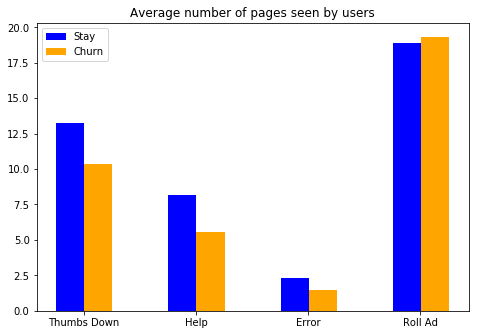

In [92]:
X = np.arange(4)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, [stayDown,stayHelp,stayError,stayAd], color = 'b', width = 0.25)
ax.bar(X + 0.25, [churnDown,churnHelp,churnError,churnAd], color = 'orange', width = 0.25)
ax.legend(labels=["Stay", "Churn"])
ax.set_title("Average number of pages seen by users")
plt.xticks(X+0.12,["Thumbs Down","Help","Error","Roll Ad"])

# Feature Engineering
We will extract features for machine learning models. For each user, we keep track of the number of songs listened, thumbs down, help, error, roll ad over time.

In [93]:
windowcum = Window.partitionBy("userId").orderBy("ts").rangeBetween(Window.unboundedPreceding, 0)
df = df.withColumn("numSong", Fsum("listen").over(windowcum))
df = df.withColumn("numThumbsDown", Fsum("ThumbsDown").over(windowcum))
df = df.withColumn("numHelp", Fsum("Help").over(windowcum))
df = df.withColumn("numError", Fsum("Error").over(windowcum))
df = df.withColumn("numAd", Fsum("Ad").over(windowcum))

In [94]:
df.select(["ts", "page","song", "numSong","numThumbsDown","numHelp","numAd", "Churn"]).where(df.userId == "100014").sort("ts").head()

Row(ts=1539177136000, page='NextSong', song='Welcome To The World of The Plastic Beach (Feat. Snoop Dogg and Hypnotic Brass Ensemble)', numSong=1, numThumbsDown=0, numHelp=0, numAd=0, Churn=1)

In [95]:
# label encoding for page as additional feature
indexer = StringIndexer(inputCol="page", outputCol="pageLabel")
df = indexer.fit(df).transform(df)
df.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', cancel=0, Churn=0, listen=1, ThumbsDown=0, Help=0, Error=0, Ad=0, numSong=1, numThumbsDown=0, numHelp=0, numError=0, numAd=0, pageLabel=0.0)

In [96]:
get_date = udf(lambda x: str(datetime.datetime.fromtimestamp(x / 1000.0).date()))
df = df.withColumn("date",get_date(df.ts))

The number of songs listened per day could also be a good feature for user behaviors.

In [97]:
windowall = Window.partitionBy("userId","date").orderBy("ts").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df = df.withColumn("numSongPerDay", Fsum("listen").over(windowall))

# Modeling
We split dataset into 80% training, 10% test and 10% validation. Models will be built on training set and evaluated on test set. Then, we report final result on validation set.

### Data Preprocessing

In [98]:
# features in vector for building model
assembler = VectorAssembler(inputCols=["pageLabel","numSong","numThumbsDown","numHelp","numError","numAd","numSongPerDay"], outputCol="featuresVec")
df = assembler.transform(df)

In [99]:
# number of songs has different scale
scaler = Normalizer(inputCol="featuresVec", outputCol="featuresNormalized")
df = scaler.transform(df)

In [100]:
data = df.select(col("userId"),col("Churn").alias("label"), col("featuresNormalized").alias("features"))
data.head()

Row(userId='100', label=0, features=DenseVector([0.002, 0.9997, 0.0111, 0.004, 0.0, 0.001, 0.0191]))

In [101]:
train, rest = data.randomSplit([0.8,0.2], seed = 42)
test, validation = rest.randomSplit([0.5,0.5], seed=42)

Logistic Regression, Random Forest, and Linear Support Vector Classification are the models used. We also fine tune hyperparameters on each of them.

### Machine Learning models

In [102]:
logreg =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)
logParamGrid = ParamGridBuilder() \
    .addGrid(logreg.elasticNetParam,[0.0, 0.3]) \
    .addGrid(logreg.maxIter,[5, 10]) \
    .build()


logCV = CrossValidator(estimator=logreg,
                          estimatorParamMaps=logParamGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol='label',metricName='f1'),
                          numFolds=3)
logCvModel = logCV.fit(train)

In [103]:
logCvModel.avgMetrics

[0.7660260006601995,
 0.7666595866781354,
 0.7660260006601995,
 0.7666595866781354]

In [117]:
logCvModel.bestModel._java_obj.getElasticNetParam()

0.0

In [118]:
logCvModel.bestModel._java_obj.getMaxIter()

10

In [43]:
# Logistic Regression evaluated on test set
preds = logCvModel.transform(test)
print(preds.filter(preds.prediction == preds.label).count()/preds.count())

0.8381627731183183


In [122]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10, maxDepth = 3)
rfParamGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees,[10,30]) \
    .addGrid(rf.maxDepth,[3, 5]) \
    .build()  

rfCV = CrossValidator(estimator=rf,
                          estimatorParamMaps=rfParamGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol='label',metricName='f1'),
                          numFolds=3)
rfCvModel = rfCV.fit(train)

In [123]:
rfCvModel.avgMetrics

[0.7656697312189749,
 0.7748783811498049,
 0.7650655920064284,
 0.7763188766133573]

In [126]:
rfCvModel.bestModel._java_obj.getNumTrees()

30

In [127]:
rfCvModel.bestModel._java_obj.getMaxDepth()

5

In [46]:
# Random Forest evaluated on test set
preds = rfCvModel.transform(test)
print(preds.filter(preds.prediction == preds.label).count()/preds.count())

0.8465138043986897


In [133]:
rfCvModel.bestModel.featureImportances

SparseVector(7, {0: 0.0003, 1: 0.1926, 2: 0.2086, 3: 0.0847, 4: 0.1179, 5: 0.31, 6: 0.0859})

In [144]:
featureim = rfCvModel.bestModel.featureImportances.toArray()
featureim

array([  2.91917487e-04,   1.92587804e-01,   2.08629049e-01,
         8.47253567e-02,   1.17853075e-01,   3.10017702e-01,
         8.58950951e-02])

([<matplotlib.axis.XTick at 0x7f0853fe2320>,
 <a list of 7 Text xticklabel objects>)

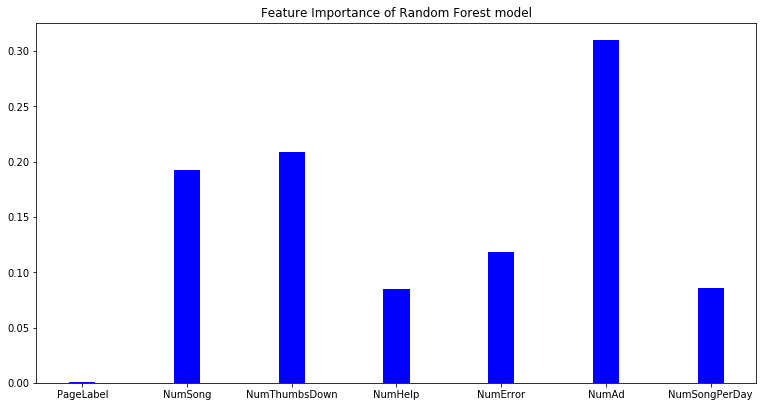

In [149]:
X = np.arange(7)
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, featureim, color = 'b', width = 0.25)
ax.set_title("Feature Importance of Random Forest model")
plt.xticks(X,["PageLabel","NumSong","NumThumbsDown","NumHelp","NumError","NumAd","NumSongPerDay"])

In [124]:
lsvc = LinearSVC(maxIter=10, regParam=0.1)
lsvcParamGrid = ParamGridBuilder() \
    .addGrid(lsvc.maxIter,[5,10]) \
    .addGrid(lsvc.regParam,[0.1, 0.8]) \
    .build()  

lsvcCV = CrossValidator(estimator=lsvc,
                          estimatorParamMaps=lsvcParamGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol='label',metricName='f1'),
                          numFolds=3)
lsvcCvModel = lsvcCV.fit(train)

In [125]:
lsvcCvModel.avgMetrics

[0.7650655920064284,
 0.7650655920064284,
 0.7650655920064284,
 0.7650655920064284]

In [128]:
lsvcCvModel.bestModel._java_obj.getMaxIter()

5

In [129]:
lsvcCvModel.bestModel._java_obj.getRegParam()

0.1

In [49]:
# Linear Support Vector evaluated on test set
preds = lsvcCvModel.transform(test)
print(preds.filter(preds.prediction == preds.label).count()/preds.count())

0.838630718836615


In [131]:
paramScoreDF = spark.createDataFrame([("Logistic Regression","ElasticNetParam 0", "MaxIter 10", 0.7666),("Random Forest","NumTrees 30", "MaxDepth 5",0.7763),("Linear Support Vector","MaxIter 5", "RegParam 0.1", 0.7650)]).toDF(*["Models","Param1","Param2","avgMetrics"])
paramScoreDF.show()

+--------------------+-----------------+------------+----------+
|              Models|           Param1|      Param2|avgMetrics|
+--------------------+-----------------+------------+----------+
| Logistic Regression|ElasticNetParam 0|  MaxIter 10|    0.7666|
|       Random Forest|      NumTrees 30|  MaxDepth 5|    0.7763|
|Linear Support Ve...|        MaxIter 5|RegParam 0.1|     0.765|
+--------------------+-----------------+------------+----------+



In [58]:
bestDF = spark.createDataFrame([("Logistic Regression",0.83816),("Random Forest",0.84651),("Linear Support Vector",0.83863)]).toDF(*["Models","best test scores"])

In [59]:
bestDF.show()

+--------------------+----------------+
|              Models|best test scores|
+--------------------+----------------+
| Logistic Regression|         0.83816|
|       Random Forest|         0.84651|
|Linear Support Ve...|         0.83863|
+--------------------+----------------+



## Results
Random Forest performs best on the test set

In [50]:
# final result on validation set
results = rfCvModel.transform(validation)
print(results.filter(results.prediction == results.label).count()/results.count())

0.8471710926051682


Performance on validation set is slightly higher than that on test set. 